# fastText for text classification with Keras

fastText reference: https://arxiv.org/abs/1607.01759

Following tutorial: https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py

We work on IMDB dataset. From keras.io documentation: *Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".*

First of all, import packages:

In [1]:
# basic
import numpy as np

# keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb

# plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


We define a function which outputs a set n-grams given a list of integers. For example, 2-grams:

input: [1,4,9,4,1,4] output: {(4, 9), (4, 1), (1, 4), (9, 4)}

In [2]:
def create_ngram_set(input_list, ngram_value=2):
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))

# set remove duplicates, * unpacks list before zipping

In [3]:
# for example:
input_list = [1,2,3,4]
n = 2
create_ngram_set(input_list, n)

{(1, 2), (2, 3), (3, 4)}

Next, we define a function which add n-grams to a list of lists (sequences):

In [4]:
def add_ngram(sequences, token_indices, ngram_range=2):
    new_sequences = [] # initialize empty list
    for input_list in sequences: # cycle through sub-lists
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indices:
                    new_list.append(token_indices[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [5]:
# for example
sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
token_indices = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
add_ngram(sequences, token_indices)

[[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

Initialize some hyperparameters:

In [6]:
ngram_range = 1 # we start with 1-grams
max_features = 20000 # cut features in text after this many words
maxlen = 400 # maximum length of sequences
batch_size = 32
embedding_dims = 50
epochs = 5

Prepare the data:

In [7]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


Padding, to obtain all sequences of the same length:

In [8]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 400)
x_test shape: (25000, 400)


Define model:

In [9]:
model = Sequential() # initialize

model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen)) # embeddings

# GlobalAveragePooling1D, which will average the embeddings of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


Compile:

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 400, 50)           1000000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________


Train model:

In [11]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 19s 755us/step - loss: 0.6123 - acc: 0.7436 - val_loss: 0.5048 - val_acc: 0.8227
Epoch 2/5
25000/25000 [==============================] - 19s 768us/step - loss: 0.4057 - acc: 0.8634 - val_loss: 0.3738 - val_acc: 0.8646
Epoch 3/5
25000/25000 [==============================] - 19s 756us/step - loss: 0.3061 - acc: 0.8934 - val_loss: 0.3219 - val_acc: 0.8783
Epoch 4/5
25000/25000 [==============================] - 19s 779us/step - loss: 0.2550 - acc: 0.9110 - val_loss: 0.2970 - val_acc: 0.8853
Epoch 5/5
25000/25000 [==============================] - 20s 786us/step - loss: 0.2206 - acc: 0.9248 - val_loss: 0.2843 - val_acc: 0.8879


Evaluate the model in terms of loss and accuracy on both training and validation set:

In [12]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9346
Testing Accuracy:  0.8879


A nice function to plot the history through the epochs:

In [13]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

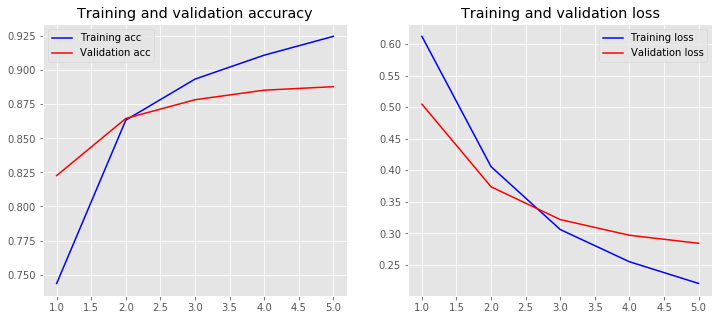

In [14]:
# display
plot_history(history)

Cool. No overfitting and pretty good accuracy. Can we do better with 2-grams?

First, re-build training and testing datasets

In [15]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


Next, set ngram_range to 2 and add 2-grams to features:

In [16]:
ngram_range = 2

if ngram_range > 1:
    print('Adding {}-gram features...'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Done!')

Adding 2-gram features...
Done!


Padding:

In [17]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 400)
x_test shape: (25000, 400)


Re-compile and re-train model:

In [18]:
model = Sequential() # initialize
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen)) # embeddings
# GlobalAveragePooling1D, which will average the embeddings of all words in the document
model.add(GlobalAveragePooling1D())
# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # compile

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test)) # train

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 419s 17ms/step - loss: 0.5862 - acc: 0.7874 - val_loss: 0.4372 - val_acc: 0.8548
Epoch 2/5
25000/25000 [==============================] - 452s 18ms/step - loss: 0.2878 - acc: 0.9276 - val_loss: 0.3031 - val_acc: 0.8904
Epoch 3/5
25000/25000 [==============================] - 477s 19ms/step - loss: 0.1432 - acc: 0.9696 - val_loss: 0.2628 - val_acc: 0.8998
Epoch 4/5
25000/25000 [==============================] - 456s 18ms/step - loss: 0.0775 - acc: 0.9871 - val_loss: 0.2441 - val_acc: 0.9030
Epoch 5/5
25000/25000 [==============================] - 468s 19ms/step - loss: 0.0437 - acc: 0.9950 - val_loss: 0.2376 - val_acc: 0.9040


Evaluate and make plots:

Training Accuracy: 0.9976
Testing Accuracy:  0.9040


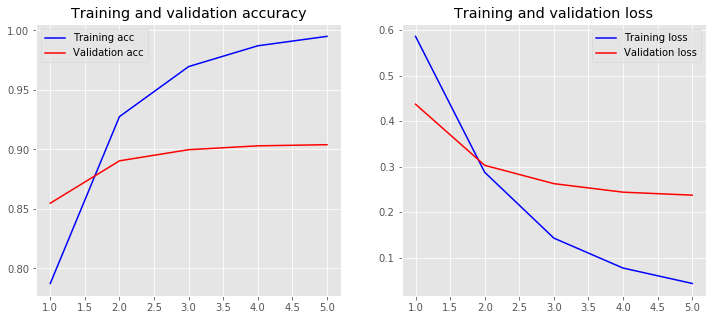

In [19]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

5 epochs show no overfitting, so accuracy on validation set might improbve with more epochs.